In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os
import random

In [17]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [18]:
data_water=parse.parse('SMHIdata/cloudrm_water.dat')
data_clear=parse.parse('SMHIdata/cloudrm_clear.dat')
data_ice=parse.parse('SMHIdata/cloudrm_ice.dat')
data_mixed=parse.parse('SMHIdata/cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

In [19]:
thinmask = df_truth.COT.between(0,3.6)
semimask = df_truth.COT.between(3.6,23)
thickmask = df_truth.COT.between(23,50)


# create a new column and use np.select to assign values to it using our lists as arguments
df_truth['Thincloud'] = thinmask.astype(int)
df_truth['Semicloud'] = semimask.astype(int)
df_truth['Thickcloud'] = thickmask.astype(int)

df_truth.head(10)

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B08A,Cloud_B09,Cloud_B10,...,Sun_Zenith_Angle,Azimuth_Diff_Angle,COT,Cloud_Type,Profile_ID,GOT,Water_Vapor,Thincloud,Semicloud,Thickcloud
0,0.89822,0.82430,0.84322,0.75232,0.79863,0.86702,0.75245,0.91433,0.38607,0.03711,...,56.99,22.96,23.397,2,8973,0.129,6.37,0,0,1
1,0.29968,0.27558,0.37609,0.27122,0.48121,0.90663,0.86953,0.91666,0.40817,0.01788,...,60.32,81.41,2.452,2,3598,0.123,0.46,1,0,0
2,0.37579,0.39177,0.55448,0.47159,0.79124,0.93204,0.88240,0.94466,0.37695,0.01356,...,55.76,50.24,6.564,5,9625,0.122,0.69,0,1,0
3,0.73411,0.70360,0.76401,0.74330,0.80824,0.99764,0.89247,1.03605,0.41092,0.00615,...,44.21,106.95,29.710,3,6165,0.128,2.96,0,0,1
4,0.61763,0.60034,0.65471,0.70713,0.73157,0.75289,0.76990,0.79839,0.66608,0.18275,...,40.58,172.91,17.975,4,2862,0.105,0.10,0,1,0
5,0.44269,0.41916,0.48508,0.41187,0.55872,1.06146,0.96138,1.08698,0.17364,0.00036,...,37.10,34.41,8.038,5,5511,0.128,2.21,0,1,0
6,0.41018,0.33676,0.38825,0.35841,0.47554,0.62465,0.58582,0.63424,0.24197,0.00661,...,79.20,178.70,10.586,5,4083,0.124,1.15,0,1,0
7,0.42340,0.41368,0.57472,0.40792,0.73594,0.95345,0.80668,0.99948,0.13464,0.00076,...,47.20,152.81,4.880,5,5923,0.128,4.09,0,1,0
8,0.66039,0.51186,0.56628,0.57571,0.59889,0.61139,0.57479,0.62094,0.17041,0.00129,...,82.55,136.21,6.280,4,1603,0.126,0.68,0,1,0
9,0.56614,0.51117,0.56691,0.51049,0.61725,0.75113,0.64290,0.78767,0.11356,0.00043,...,69.07,121.27,20.479,4,8279,0.123,5.44,0,1,0


In [20]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B08A','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle','Thincloud','Semicloud','Thickcloud']

y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B08A','Clear_B09','Clear_B10','Clear_B11','Clear_B12']


##Split data##
X=df_truth[X_labels]
y=df_truth[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05,random_state=313)

np.random.seed(313)
X_test = X_test + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]) * np.mean(X.to_numpy(),axis=0)*0.03

In [21]:
quantiles=np.array([0.1,0.5,0.9])
no_nodes=200

sequence= lambda: nn.Sequential(
    nn.Linear(len(X_labels),no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)

In [22]:
val_size=0.05
batch_size=500 

lr_s=[0.003]

num_models=5 #Set number of ensambles
batch_size=500
nepochs=1000
lr=0.003
noise_ratio = 0.03
early_break=True

looped_metric="Loop_learning_rate"
main_filepath='pytorch_models/'+looped_metric

model_metrics=pd.DataFrame(columns=['Ensemble_mean','Ensemble_index',looped_metric,'MSE','PSNR','R2_score','Mean_Quantile_Loss','Quant_Rate','Quantiles'])
for lr in lr_s:

    
    models=[QuantileNetwork(quantiles=quantiles) for _ in range(num_models)]
    preds_total=[]
    for i,model in enumerate(models): 

        validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
        train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]       

        model.fit(X_train.to_numpy(),y_train.to_numpy(), 
            train_indices, 
            validation_indices, 
            batch_size=batch_size,
            nepochs=nepochs,
            sequence=sequence(),
            lr=lr,
            noise_ratio=noise_ratio,
            early_break=early_break)
        
        filepath=main_filepath+'/'+str(lr)+'/model'+str(i)
        os.makedirs(filepath,exist_ok=True)
        torch.save(model,filepath+'/model_file')

        preds = model.predict(X_test.to_numpy())
        if i==0:
            preds_total=preds
        else:
            preds_total=preds_total+preds

        mse=mean_squared_error(y_test.to_numpy(),preds[:,:,1])
        psnr=QuantileNetwork.PSNR(y_test,preds[:,:,1])
        r2=r2_score(y_test.to_numpy(),preds[:,:,1])
        mean_quantile=QuantileNetwork.mean_marginal_loss(y_test.to_numpy(),preds,quantiles)
        quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy(),preds)

        tmp_metrics=pd.DataFrame(data=[[False,i,lr,mse,psnr,r2,mean_quantile,quant_rate,quantiles]],columns=['Ensemble_mean','Ensemble_index',looped_metric,'MSE','PSNR','R2_score','Mean_Quantile_Loss','Quant_Rate','Quantiles'])
        model_metrics=pd.concat([model_metrics,tmp_metrics])
    
    preds_total=preds_total/num_models

    mse=mean_squared_error(y_test.to_numpy(),preds_total[:,:,1])
    psnr=QuantileNetwork.PSNR(y_test,preds_total[:,:,1])
    r2=r2_score(y_test.to_numpy(),preds_total[:,:,1])
    mean_quantile=QuantileNetwork.mean_marginal_loss(y_test.to_numpy(),preds_total,quantiles)
    quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy(),preds_total)

    tmp_metrics=pd.DataFrame(data=[[True,np.nan,lr,mse,psnr,r2,mean_quantile,quant_rate,quantiles]],columns=['Ensemble_mean','Ensemble_index',looped_metric,'MSE','PSNR','R2_score','Mean_Quantile_Loss','Quant_Rate','Quantiles'])
    model_metrics=pd.concat([model_metrics,tmp_metrics])


X_test.to_csv(main_filepath+'/xtest.csv',index=False)
y_test.to_csv(main_filepath+'/ytest.csv',index=False)

model_metrics=model_metrics.reset_index(drop=True)
model_metrics.to_csv(main_filepath+'/model_metrics.csv',index=False)

Epoch 241


Batch number: 100%|██████████| 361/361 [00:01<00:00, 331.35it/s]

Training loss [1.5157771] Validation loss [1.5299835]
Epoch 242



Batch number: 100%|██████████| 361/361 [00:01<00:00, 336.41it/s]

Training loss [1.518704] Validation loss [1.5346678]
Epoch 243



Batch number: 100%|██████████| 361/361 [00:01<00:00, 340.65it/s]

Training loss [1.5219532] Validation loss [1.5374128]
Epoch 244



Batch number: 100%|██████████| 361/361 [00:01<00:00, 340.41it/s]

Training loss [1.5165625] Validation loss [1.553682]
Epoch 245



Batch number: 100%|██████████| 361/361 [00:01<00:00, 340.07it/s]

Training loss [1.5170034] Validation loss [1.5349572]


---No improvement in 100 epochs, broke early---
Best model out of total max epochs found at epoch 145
With validation loss: 1.5217591524124146


In [23]:
model_metrics

,Ensemble_mean,Ensemble_index,Loop_learning_rate,MSE,PSNR,R2_score,Mean_Quantile_Loss,Quant_Rate,Quantiles
0,False,0,0.003,0.006045,26.872709,0.922798,0.446009,"[0.08335, 0.45365833333333333, 0.8603]","[0.1, 0.5, 0.9]"
1,False,1,0.003,0.006074,26.852045,0.922717,0.440256,"[0.09025833333333333, 0.46475833333333333, 0.8...","[0.1, 0.5, 0.9]"
2,False,2,0.003,0.006051,26.868366,0.922934,0.439741,"[0.10443333333333334, 0.478475, 0.877566666666...","[0.1, 0.5, 0.9]"
3,False,3,0.003,0.006151,26.797602,0.921619,0.441731,"[0.083625, 0.43045, 0.857375]","[0.1, 0.5, 0.9]"
4,False,4,0.003,0.006140,26.805360,0.921623,0.441577,"[0.135675, 0.5066916666666667, 0.88555]","[0.1, 0.5, 0.9]"
5,True,NaN,0.003,0.005741,27.097378,0.926873,0.421516,"[0.0718, 0.46585, 0.8986916666666667]","[0.1, 0.5, 0.9]"


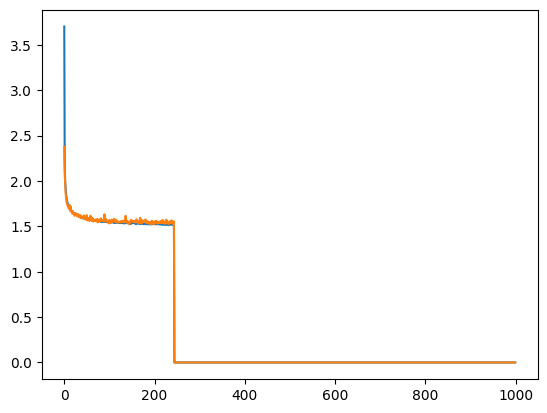

In [24]:
plt.figure()
plt.plot(model.train_loss.cpu())
plt.plot(model.val_loss.cpu())
plt.show()

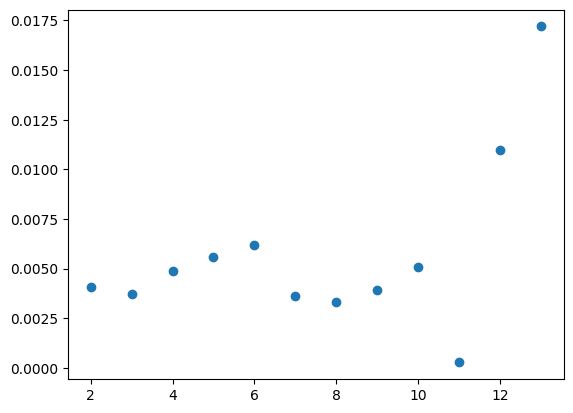

In [25]:
MSE_col = np.mean((preds_total[:,:,1]-y_test.to_numpy())**2,axis=0)
x=np.arange(2,np.size(MSE_col)+2)
plt.figure()
plt.scatter(x,MSE_col)
plt.show()

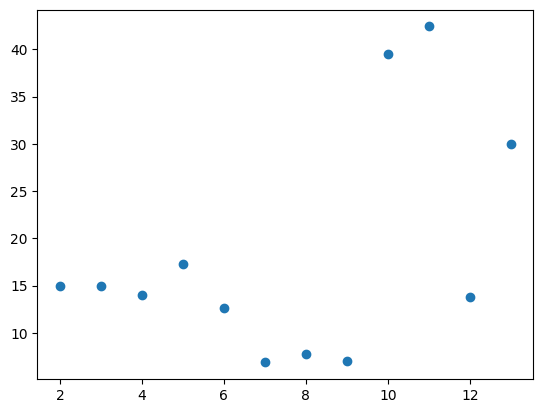

In [26]:
error_percent = 100*np.divide(np.abs(preds_total[:,:,1]-y_test.to_numpy()),y_test.to_numpy())

err_perc_col = np.mean(error_percent,axis=0)

plt.figure()
plt.scatter(x,err_perc_col)
plt.show()

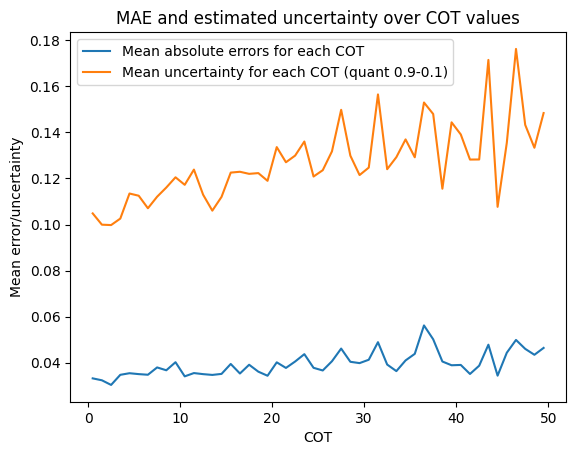

In [27]:
#Find COTs of all test points
testindices=y_test.index
COTs=np.array(df_truth['COT'].iloc[testindices])

#find sorted numpy indices and sort COT array
COTidx=np.argsort(COTs)
COT_sorted = COTs[COTidx]

#sort numpy test and preds by COT
y_test_np_sort=np.array(y_test)[COTidx,:]
y_pred_sort=preds_total[COTidx,:,:]

#Find errors and uncs for band 11
all_bands=True
if all_bands:
    errors = np.mean(np.abs(y_test_np_sort[:,:]-y_pred_sort[:,:,1]),axis=1)
    uncs = np.mean(y_pred_sort[:,:,2]-y_pred_sort[:,:,0],axis=1)
else:
    band = 10
    errors = np.abs(y_test_np_sort[:,band]-y_pred_sort[:,band,1])
    uncs = y_pred_sort[:,band,2]-y_pred_sort[:,band,0]

#sort errors and uncs into bins based on COT
COTedges=np.linspace(0,50,51)
err_bins = np.zeros(len(COTedges)-1)
unc_bins = np.zeros(len(COTedges)-1)
bin_freq = np.zeros(len(COTedges)-1)

for i in range(len(COT_sorted)):
    for j in range(len(COTedges)-1):   
        if COT_sorted[i] > COTedges[j] and COT_sorted[i] < COTedges[j+1]:
            err_bins[j] = err_bins[j] + errors[i]
            unc_bins[j] = unc_bins[j] + uncs[i]
            bin_freq[j] = bin_freq[j] + 1
            break

#Find mean errs and uncs in each bin
err_mean_bins = err_bins/bin_freq
unc_mean_bins = unc_bins/bin_freq

x=COTedges[:-1]+0.5
plt.figure()
plt.plot(x,err_mean_bins)
plt.plot(x,unc_mean_bins)
plt.title('MAE and estimated uncertainty over COT values')
plt.legend(['Mean absolute errors for each COT','Mean uncertainty for each COT (quant 0.9-0.1)'])
plt.xlabel('COT')
plt.ylabel('Mean error/uncertainty')
plt.show()



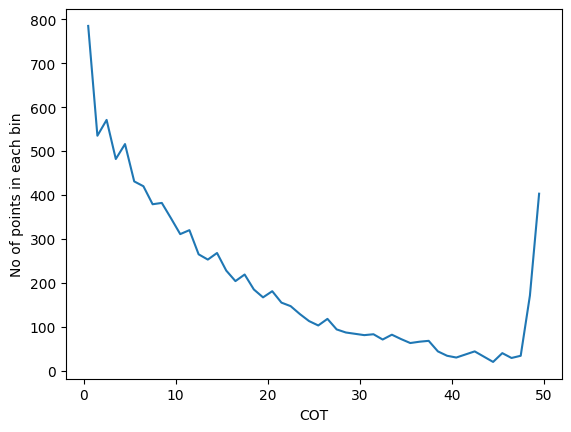

In [28]:
plt.figure()
plt.plot(x,bin_freq)
plt.ylabel('No of points in each bin')
plt.xlabel('COT')
plt.show()

In [29]:
A=np.linspace(0,50,21)
print(A)
B=A[:-1]+1.25
print(B)

[ 0.   2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5 25.  27.5 30.  32.5
 35.  37.5 40.  42.5 45.  47.5 50. ]
[ 1.25  3.75  6.25  8.75 11.25 13.75 16.25 18.75 21.25 23.75 26.25 28.75
 31.25 33.75 36.25 38.75 41.25 43.75 46.25 48.75]
